In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import read_structure, molecule
from matplotlib import pyplot as plt


In [ ]:
# 1. define H2 molecule structure
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.74]])  # 0.74 Å is H-H average bond length


In [6]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, active_electrons=2, active_orbitals=2)
print("使用 qubits 数量:", qubits)

使用 qubits 数量: 4


In [7]:
# 3. 定义量子设备
dev = qml.device("default.qubit", wires=qubits)

In [8]:
def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

driver_h = build_driver_h(qubits)

In [9]:
# 5. 构造 commutator 哈密顿量（手动构造 [H_d, H_c]）
def build_commutator_h(cost_h, driver_h):
    # 简单地估算 [H_d, H_c] 的形式：对每对项手动计算 [X, Z] ≈ 2iY
    # 注意：这里只是近似表示，可使用 qml 的 sparse matrix 或 commutator 工具进一步改进
    comm_terms = []
    for cd, od in zip(driver_h.coeffs, driver_h.ops):
        for cc, oc in zip(cost_h.coeffs, cost_h.ops):
            if od.wires == oc.wires:
                wire = od.wires[0]
                # [X, Z] = 2i Y → 取虚部，忽略 i，只保留 Y 项
                comm_terms.append((2.0 * cd * cc, qml.PauliY(wire)))

    if not comm_terms:
        return qml.Hamiltonian([0.0], [qml.Identity(0)])
    coeffs, ops = zip(*comm_terms)
    return qml.Hamiltonian(coeffs, ops)

comm_h = build_commutator_h(H, driver_h)

/root/miniconda3/envs/FBQA_Hydrogen/lib/python3.10/site-packages/pennylane/ops/op_math/sum.py:541: PennyLaneDeprecationWarning: Sum.coeffs is deprecated and will be removed in future releases. You can access both (coeffs, ops) via op.terms(). Also consider op.operands.
  warnings.warn(
/root/miniconda3/envs/FBQA_Hydrogen/lib/python3.10/site-packages/pennylane/ops/op_math/sum.py:557: PennyLaneDeprecationWarning: Sum.ops is deprecated and will be removed in future releases. You can access both (coeffs, ops) via op.terms(). Also consider op.operands.
  warnings.warn(


In [11]:
# 6. 构建 FALQON 演化层
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)


In [12]:
# 7. 构建 ansatz（多层 feedback 演化）
def build_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(falqon_layer, len(beta), beta,
                  cost_h=cost_h, driver_h=driver_h, delta_t=delta_t)
    return ansatz

In [13]:
# 8. 构建测量电路（测量 cost_h 或 comm_h 的期望值）
def expval_circuit(beta, measurement_h):
    ansatz = build_ansatz(H, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

In [14]:
# 9. 主过程：运行 FBQA，生成 β 序列与能量估计
def run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

    for i in range(n_steps):
        # 用 commutator 哈密顿量测量当前态，得到下一层 feedback 参数
        next_beta = -delta_t * cost_fn(beta_list, measurement_h=comm_h)
        beta_list.append(next_beta)

        # 计算当前 ansatz 态的能量期望
        energy = cost_fn(beta_list, measurement_h=H)
        energy_list.append(energy)
        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

In [15]:
# 10. 参数设定并运行
n_steps = 40
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t)

第 1 步: E = 0.77740032 Ha, β_1 = 0.021449
第 2 步: E = 0.77313303 Ha, β_2 = 0.042486
第 3 步: E = 0.76468343 Ha, β_3 = 0.062714
第 4 步: E = 0.75118801 Ha, β_4 = 0.081764
第 5 步: E = 0.73218405 Ha, β_5 = 0.099294
第 6 步: E = 0.70764094 Ha, β_6 = 0.115003
第 7 步: E = 0.67795044 Ha, β_7 = 0.128642
第 8 步: E = 0.64387632 Ha, β_8 = 0.140018
第 9 步: E = 0.60647007 Ha, β_9 = 0.149001
第 10 步: E = 0.56696397 Ha, β_10 = 0.155534
第 11 步: E = 0.52665632 Ha, β_11 = 0.159626
第 12 步: E = 0.48680326 Ha, β_12 = 0.161358
第 13 步: E = 0.44852944 Ha, β_13 = 0.160870
第 14 步: E = 0.41276483 Ha, β_14 = 0.158356
第 15 步: E = 0.38020986 Ha, β_15 = 0.154047
第 16 步: E = 0.35132657 Ha, β_16 = 0.148203
第 17 步: E = 0.32635045 Ha, β_17 = 0.141099
第 18 步: E = 0.30531650 Ha, β_18 = 0.133009
第 19 步: E = 0.28809319 Ha, β_19 = 0.124202
第 20 步: E = 0.27441961 Ha, β_20 = 0.114929
第 21 步: E = 0.26394206 Ha, β_21 = 0.105419
第 22 步: E = 0.25624819 Ha, β_22 = 0.095878
第 23 步: E = 0.25089743 Ha, β_23 = 0.086483
第 24 步: E = 0.24744710 Ha, β_

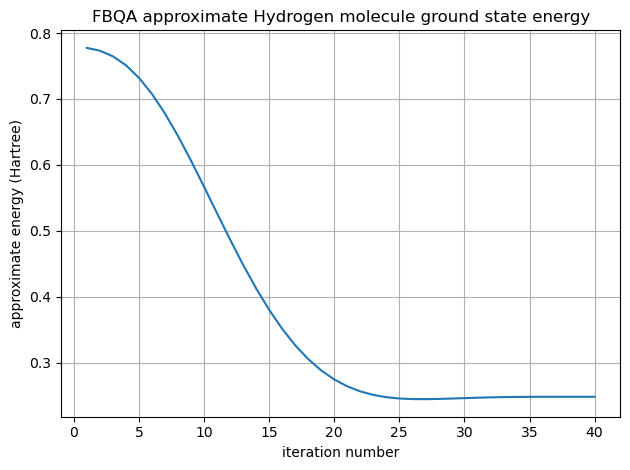

In [20]:
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("iteration number")
plt.ylabel("approximate energy (Hartree)")
plt.title("FBQA approximate Hydrogen molecule ground state energy")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import numpy as np

symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74]  # 单位是 Å
])



In [30]:
from pennylane import qchem

H_c, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method='pyscf',
    basis='sto-3g'
)
print(H_c)

0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))


In [26]:
def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

driver_h = build_driver_h(qubits)
print(driver_h)


-1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)


In [35]:
from pennylane import commutator
from pennylane import commutator, Hamiltonian

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []

    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()

    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                # 检查 comm 是不是空的 Sum（即“无对易项”）
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue  # 是空项就跳过
                comm_terms.append(c1 * c2 * comm)
            except Exception as e:
                print(f"跳过某个项：[{op1}, {op2}] 计算 commutator 出错，原因：{e}")
                continue

    if len(comm_terms) == 0:
        print("所有 commutators 都是 0")
        return Hamiltonian([], [])
    
    # 合并所有项
    full_comm = sum(comm_terms)
    return full_comm.simplify()



commh_h = build_commutator_hamiltonian(driver_h,H_c)
print(comm_h)

-0.4743748006099693 * Y(0) + -0.47437480060996917 * Y(1) + 0.9224991415264475 * Y(2) + 0.9224991415264476 * Y(3)


In [ ]:
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)